## Installing Libraries:

In [1]:
import os, sys, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve, auc
from scipy.stats import randint, uniform

import plotly.express as px
from IPython.display import display, HTML

try:
    from xgboost import XGBClassifier
    HAS_XGB = True
except Exception:
    HAS_XGB = False

USE_SMOTE = False
try:
    if USE_SMOTE:
        from imblearn.over_sampling import SMOTE
        HAS_SMOTE = True
    else:
        HAS_SMOTE = False
except Exception:
    HAS_SMOTE = False
    USE_SMOTE = False

## User-configurable:

In [2]:
os.chdir("H:/Nyberman Internship/Phase II/Project Dataset")
cc_df = pd.read_csv("colon_cancer_vs_control.csv")
RANDOM_SEED = 42

VAR_THRESHOLD = 1e-5
K_SELECT      = 4000

N_PCS      = 30
VAR_TARGET = None

TEST_SIZE = 0.2
CV_FOLDS  = 10
N_ITER_RS = 60
N_JOBS    = -1

## Helpers:

In [3]:
COMMON_LABELS = ["diagnosis","label","class","target","Status","status","Group","group","Condition","condition"]

def smart_find_label(df: pd.DataFrame):
    for c in COMMON_LABELS:
        if c in df.columns:
            return c
    return None

def coerce_binary_labels(series: pd.Series):
    s = series.copy()
    if s.dtype == "O":
        mapping_candidates = [
            {"M":1, "B":0},
            {"Malignant":1, "Benign":0},
            {"Cancer":1, "Control":0},
            {"Case":1, "Control":0},
            {"Tumor":1, "Normal":0},
            {"Yes":1, "No":0},
        ]
        vals = set(map(str, s.dropna().unique()))
        for mp in mapping_candidates:
            if vals.issubset(set(map(str, mp.keys()))):
                return s.map(mp)
    return s

def ensure_out(path="pca_improved_outputs_noensemble"):
    os.makedirs(path, exist_ok=True)
    return path

def save_cm_csv(y_true, y_pred, name, outdir):
    cm = confusion_matrix(y_true, y_pred)
    pd.DataFrame(cm, index=["True_0","True_1"], columns=["Pred_0","Pred_1"]).to_csv(os.path.join(outdir, name))
    print(f"[Saved] {os.path.join(outdir, name)}")
    return cm

def plot_confusion_matrix_matplotlib(cm, title="Confusion Matrix"):
    plt.figure(figsize=(4.8,4.2))
    plt.imshow(cm, interpolation='nearest', aspect='auto')
    plt.title(title); plt.colorbar()
    ticks = np.arange(2)
    plt.xticks(ticks, ['Pred 0','Pred 1']); plt.yticks(ticks, ['True 0','True 1'])
    thresh = cm.max()/2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, f"{cm[i,j]:d}", ha="center", va="center",
                     color="white" if cm[i,j] > thresh else "black")
    plt.tight_layout(); plt.xlabel("Predicted"); plt.ylabel("True"); plt.show()

## Load & prep:

In [5]:
np.random.seed(RANDOM_SEED)
csv_path = os.path.join("H:/Nyberman Internship/Phase II/Project Dataset", "colon_cancer_vs_control.csv")
outdir = ensure_out()
if not os.path.exists(csv_path):
    print(f"[ERROR] File not found: {csv_path}", file=sys.stderr); raise SystemExit(1)

df = pd.read_csv(csv_path)
display(df.head()); print("Shape:", df.shape); display(df.dtypes)

na_full = df.columns[df.isna().all()].tolist()
if na_full:
    print(f"[Info] Dropping fully-NA columns: {na_full}"); df = df.drop(columns=na_full)

label_col = smart_find_label(df)
if not label_col: raise ValueError("No label column detected (e.g., 'diagnosis', 'class').")
df[label_col] = coerce_binary_labels(df[label_col])
y = pd.Categorical(df[label_col]).codes if not pd.api.types.is_numeric_dtype(df[label_col]) else df[label_col].values

X = df.drop(columns=[label_col])
X_num = X.select_dtypes(include=[np.number]).copy()
non_num = [c for c in X.columns if c not in X_num.columns]
if non_num: print(f"[Info] Ignoring non-numeric columns: {non_num}")
if X_num.shape[1] < 2: raise ValueError("Not enough numeric columns.")

X_train, X_test, y_train, y_test = train_test_split(X_num.values, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_SEED)
print(f"[Split] train={X_train.shape}, test={X_test.shape}, y_train sum={y_train.sum()}, y_test sum={y_test.sum()}")

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

if VAR_THRESHOLD is not None and VAR_THRESHOLD > 0:
    vt = VarianceThreshold(threshold=VAR_THRESHOLD)
    X_train_s = vt.fit_transform(X_train_s)
    X_test_s  = vt.transform(X_test_s)
    print(f"[FS] After VarianceThreshold: {X_train_s.shape}")

skb = SelectKBest(score_func=f_classif, k=min(K_SELECT, X_train_s.shape[1]))
X_train_sel = skb.fit_transform(X_train_s, y_train)
X_test_sel  = skb.transform(X_test_s)
print(f"[FS] After SelectKBest(k={skb.k}): {X_train_sel.shape}")

,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,AADAC,...,ETV3L,ETV4,ETV5,ETV6,ETV7,EVA1A,EVA1B,EVA1C,label,batch
0,3,197,62,48,92,21,226,403,71,15,...,126,15,68,18,10,6,11,11,condition,batch_3
1,17,248,121,77,230,52,128,732,105,11,...,302,14,125,21,63,12,71,4,condition,batch_3
2,23,342,119,120,175,35,462,427,94,9,...,140,16,80,47,2,51,20,6,condition,batch_3
3,16,189,244,21,141,163,2092,759,146,47,...,432,35,196,45,7,10,43,5,condition,batch_3
4,6,96,69,51,288,52,168,915,97,9,...,275,11,137,17,35,10,30,8,condition,batch_3


Shape: (208, 19299)


A1BG        int64
A1CF        int64
A2M         int64
A2ML1       int64
A3GALT2     int64
            ...  
EVA1A       int64
EVA1B       int64
EVA1C       int64
label      object
batch      object
Length: 19299, dtype: object

[Info] Ignoring non-numeric columns: ['batch']
[Split] train=(166, 19297), test=(42, 19297), y_train sum=83, y_test sum=21
[FS] After VarianceThreshold: (166, 19297)
[FS] After SelectKBest(k=4000): (166, 4000)


## PCA Analysis:

In [6]:
if N_PCS is None and VAR_TARGET is None: N_PCS = 30
pca = PCA(n_components=N_PCS if N_PCS is not None else VAR_TARGET, svd_solver="auto", random_state=RANDOM_SEED)
X_train_pca = pca.fit_transform(X_train_sel); X_test_pca = pca.transform(X_test_sel)

## Visualizations:

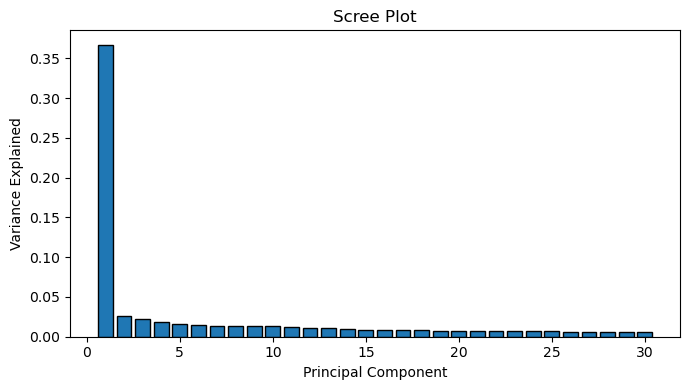

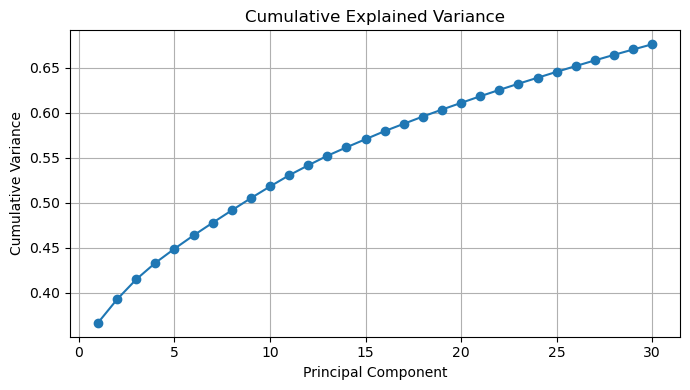

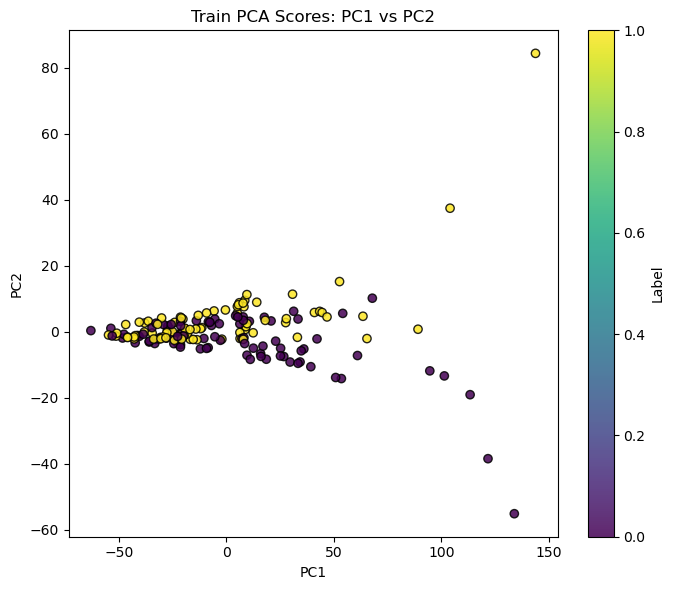

[Saved] pca_improved_outputs_noensemble\viz_train_pca3d.html


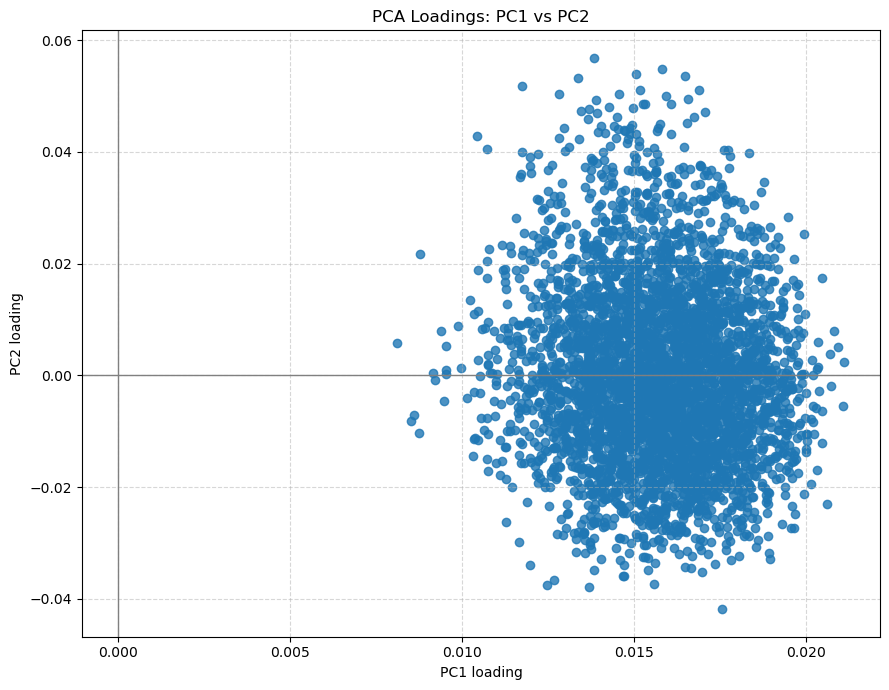

In [7]:
explained = pca.explained_variance_ratio_; cumexp = np.cumsum(explained)

plt.figure(figsize=(7,4)); plt.bar(range(1, len(explained)+1), explained, edgecolor="black")
plt.title("Scree Plot"); plt.xlabel("Principal Component"); plt.ylabel("Variance Explained")
plt.tight_layout(); plt.savefig(os.path.join(outdir, "viz_scree.png"), dpi=300); plt.show()

plt.figure(figsize=(7,4)); plt.plot(range(1, len(cumexp)+1), cumexp, marker="o")
plt.title("Cumulative Explained Variance"); plt.xlabel("Principal Component"); plt.ylabel("Cumulative Variance")
plt.grid(True); plt.tight_layout(); plt.savefig(os.path.join(outdir, "viz_cumulative.png"), dpi=300); plt.show()

plt.figure(figsize=(7,6))
sc = plt.scatter(X_train_pca[:,0], X_train_pca[:,1], c=y_train, edgecolor="k", alpha=0.85)
cb = plt.colorbar(sc); cb.set_label("Label")
plt.title("Train PCA Scores: PC1 vs PC2"); plt.xlabel("PC1"); plt.ylabel("PC2")
plt.tight_layout(); plt.savefig(os.path.join(outdir, "viz_train_pc1_pc2.png"), dpi=300); plt.show()

train_vis = pd.DataFrame({
    "PC1": X_train_pca[:,0],
    "PC2": X_train_pca[:,1],
    "PC3": X_train_pca[:,2] if X_train_pca.shape[1] >= 3 else np.zeros(X_train_pca.shape[0]),
    "Label": y_train.astype(int)
})
fig = px.scatter_3d(train_vis, x="PC1", y="PC2", z="PC3",
                    color=train_vis["Label"].astype(str),
                    title="Train PCA: PC1–PC2–PC3")
fig.write_html(os.path.join(outdir, "viz_train_pca3d.html"))
print(f"[Saved] {os.path.join(outdir, 'viz_train_pca3d.html')}")
display(HTML(f'<a href="{os.path.join(outdir, ' + '"viz_train_pca3d.html"' + ')}" target="_blank">Open 3D PCA (train)</a>'))

loadings = pca.components_.T[:, :2]
plt.figure(figsize=(9,7)); plt.scatter(loadings[:,0], loadings[:,1], alpha=0.8)
plt.axhline(0, color="gray", linewidth=1); plt.axvline(0, color="gray", linewidth=1)
plt.title("PCA Loadings: PC1 vs PC2"); plt.xlabel("PC1 loading"); plt.ylabel("PC2 loading")
plt.grid(True, linestyle="--", alpha=0.5); plt.tight_layout(); plt.savefig(os.path.join(outdir, "viz_loadings_pc1_pc2.png"), dpi=300); plt.show()

## balance with SMOTE in the PCA space:

In [8]:
if USE_SMOTE and HAS_SMOTE:
    sm = SMOTE(random_state=RANDOM_SEED)
    X_train_model, y_train_model = sm.fit_resample(X_train_pca, y_train)
else:
    X_train_model, y_train_model = X_train_pca, y_train

## Modeling:

In [9]:
best_pca = None; best_sel = None; best_xgb = None
if not HAS_XGB:
    print("[Info] xgboost not installed; skipping all XGBoost steps.")
else:
    n_pos = (y_train_model == 1).sum(); n_neg = (y_train_model == 0).sum()
    scale_pos_weight = (n_neg / max(1, n_pos)) if n_pos > 0 else 1.0

    # Tighter, regularized search space
    xgb_base = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=RANDOM_SEED,
                             tree_method="hist", device="cpu", scale_pos_weight=scale_pos_weight)

    param_dist = {
        "n_estimators": randint(200, 700),
        "learning_rate": uniform(0.01, 0.15),
        "max_depth": randint(3, 7),
        "subsample": uniform(0.6, 0.3),
        "colsample_bytree": uniform(0.6, 0.3),
        "gamma": uniform(0.1, 0.9),
        "min_child_weight": randint(3, 9),
        "reg_alpha": uniform(0.3, 0.4),
        "reg_lambda": uniform(1.0, 1.0)
    }
    cv = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_SEED)

## (A) XGB on PCA(30 PCs):

In [10]:
rs_pca = RandomizedSearchCV(estimator=xgb_base, param_distributions=param_dist,
                            n_iter=N_ITER_RS, scoring="accuracy", cv=cv, n_jobs=N_JOBS,
                            random_state=RANDOM_SEED, verbose=1)
rs_pca.fit(X_train_model, y_train_model)
best_pca = rs_pca.best_estimator_
y_pred_A = best_pca.predict(X_test_pca)
acc_A = accuracy_score(y_test, y_pred_A)
try:
    auc_A = roc_auc_score(y_test, best_pca.predict_proba(X_test_pca)[:,1])
except Exception:
    auc_A = np.nan
with open(os.path.join(outdir, "report_A_xgb_on_pca30.json"), "w") as f:
    json.dump({"best_params": rs_pca.best_params_, "cv": rs_pca.best_score_,
                "test_acc": float(acc_A), "test_auc": float(auc_A)}, f, indent=2)

Fitting 10 folds for each of 60 candidates, totalling 600 fits


C:\Users\Himanshu\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning:

[23:26:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.




## (B) XGB on selected (no PCA):

In [11]:
rs_sel = RandomizedSearchCV(estimator=xgb_base, param_distributions=param_dist,
                            n_iter=N_ITER_RS, scoring="accuracy", cv=cv, n_jobs=N_JOBS,
                            random_state=RANDOM_SEED, verbose=1)
rs_sel.fit(X_train_sel, y_train)
best_sel = rs_sel.best_estimator_
y_pred_B = best_sel.predict(X_test_sel)
acc_B = accuracy_score(y_test, y_pred_B)
try:
    auc_B = roc_auc_score(y_test, best_sel.predict_proba(X_test_sel)[:,1])
except Exception:
    auc_B = np.nan
with open(os.path.join(outdir, "report_B_xgb_on_selected_k4000.json"), "w") as f:
    json.dump({"best_params": rs_sel.best_params_, "cv": rs_sel.best_score_,
                "test_acc": float(acc_B), "test_auc": float(auc_B)}, f, indent=2)

Fitting 10 folds for each of 60 candidates, totalling 600 fits


C:\Users\Himanshu\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning:

[23:45:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.




## (C) XGB on FIRST 5 PCs (for comparison):

In [12]:
X_train_pca5 = X_train_pca[:, :5]; X_test_pca5 = X_test_pca[:, :5]
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=RANDOM_SEED,
                        tree_method="hist", device="cpu", scale_pos_weight=scale_pos_weight)
param_user = {
    'n_estimators': randint(100, 500),
    'learning_rate': uniform(0.01, 0.3),
    'max_depth': randint(2, 8),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'gamma': uniform(0, 0.5)
}
rs_user = RandomizedSearchCV(estimator=xgb_clf, param_distributions=param_user,
                                n_iter=25, scoring='accuracy', cv=5, verbose=1, n_jobs=-1,
                                random_state=RANDOM_SEED)
rs_user.fit(X_train_pca5, y_train)
best_xgb = rs_user.best_estimator_
y_pred_C = best_xgb.predict(X_test_pca5)
acc_C = accuracy_score(y_test, y_pred_C)
try:
    auc_C = roc_auc_score(y_test, best_xgb.predict_proba(X_test_pca5)[:,1])
except Exception:
    auc_C = np.nan
with open(os.path.join(outdir, "report_C_xgb_on_first5pcs.json"), "w") as f:
    json.dump({"best_params": rs_user.best_params_, "cv_best_score": float(rs_user.best_score_),
                "test_accuracy": float(acc_C), "test_auc": float(auc_C)}, f, indent=2)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


C:\Users\Himanshu\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning:

[23:47:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.




## Confusion matrices:

[Saved] pca_improved_outputs_noensemble\cm_A_xgb_on_pca30.csv


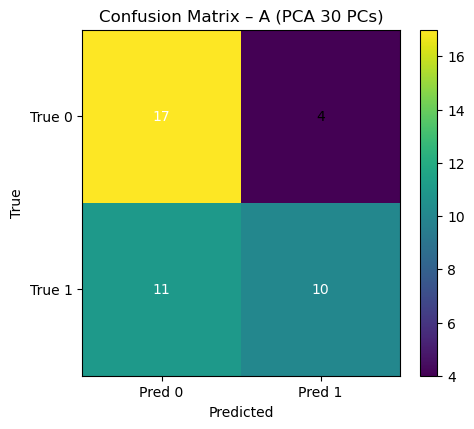

[Saved] pca_improved_outputs_noensemble\cm_B_xgb_on_selected_k4000.csv


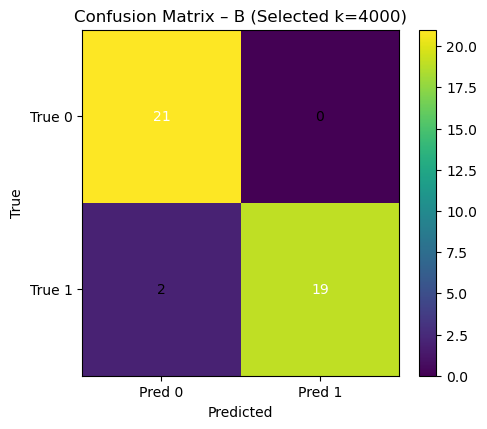

[Saved] pca_improved_outputs_noensemble\cm_C_xgb_on_first5pcs.csv


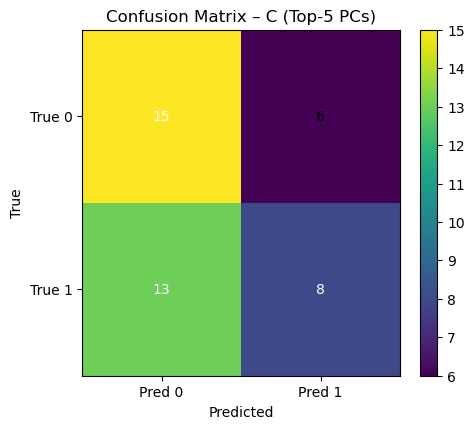

In [13]:
cmA = save_cm_csv(y_test, y_pred_A, "cm_A_xgb_on_pca30.csv", outdir); plot_confusion_matrix_matplotlib(cmA, "Confusion Matrix – A (PCA 30 PCs)")
cmB = save_cm_csv(y_test, y_pred_B, "cm_B_xgb_on_selected_k4000.csv", outdir); plot_confusion_matrix_matplotlib(cmB, "Confusion Matrix – B (Selected k=4000)")
cmC = save_cm_csv(y_test, y_pred_C, "cm_C_xgb_on_first5pcs.csv", outdir); plot_confusion_matrix_matplotlib(cmC, "Confusion Matrix – C (Top-5 PCs)")

## ROC curves:

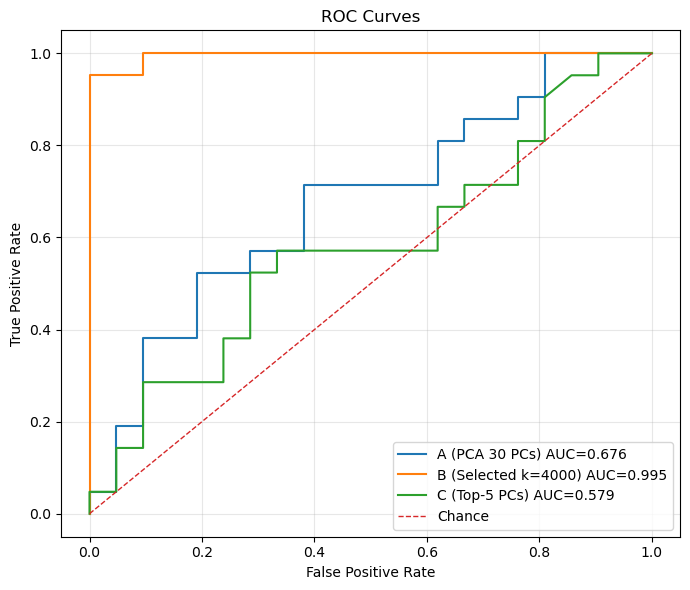


Done. Outputs stored in: H:\Nyberman Internship\Phase II\Project Dataset\pca_improved_outputs_noensemble


In [14]:
plt.figure(figsize=(7,6))
probaA = best_pca.predict_proba(X_test_pca)[:,1]
fprA, tprA, _ = roc_curve(y_test, probaA); plt.plot(fprA, tprA, label=f"A (PCA 30 PCs) AUC={auc(fprA,tprA):.3f}")
probaB = best_sel.predict_proba(X_test_sel)[:,1]
fprB, tprB, _ = roc_curve(y_test, probaB); plt.plot(fprB, tprB, label=f"B (Selected k=4000) AUC={auc(fprB,tprB):.3f}")
probaC = best_xgb.predict_proba(X_test_pca5)[:,1]
fprC, tprC, _ = roc_curve(y_test, probaC); plt.plot(fprC, tprC, label=f"C (Top-5 PCs) AUC={auc(fprC,tprC):.3f}")
plt.plot([0,1],[0,1],"--",linewidth=1,label="Chance")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate"); plt.title("ROC Curves")
plt.legend(); plt.grid(True, alpha=0.3)
plt.tight_layout(); plt.savefig(os.path.join(outdir, "viz_roc_ABC.png"), dpi=300); plt.show()

print("\nDone. Outputs stored in:", os.path.abspath(outdir))